<a href="https://colab.research.google.com/github/ismak10/Prediccion-de-demanda/blob/main/Prediccion_demanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicción de la demanda de energía mediante modelos de Machine Learning**

Ismael Kastillo

---
# Inicialización
---

In [ ]:
# Imports generales
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import random
seed = 7
random.seed(seed)
np.random.seed(seed)
colores = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]

In [ ]:
# Subir el conjunto de datos de la demanda eléctrica en España 2019-2024
url = "https://raw.githubusercontent.com/ismak10/Prediccion-de-demanda/main/demanda.csv"
demanda = pd.read_csv(url)
print(demanda.shape)
demanda.head()

(47088, 3)


Time (UTC)  Day-ahead forecast  Actual load
0  16.02.2019 00:00             25924.0      25738.0
1  16.02.2019 01:00             24457.0      24279.0
2  16.02.2019 02:00             23720.0      23519.0
3  16.02.2019 03:00             23350.0      23164.0
4  16.02.2019 04:00             23283.0      23083.0

In [ ]:
# Subir el conjunto de datos climáticos de las 3 ciudades más pobladas de España
url = "https://raw.githubusercontent.com/ismak10/Prediccion-de-demanda/main/clima.csv"
clima = pd.read_csv(url)
print(clima.shape)
clima.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(138679, 8)


IdProvincia                Fecha  Precipitación pluviómetro  \
0      Madrid  2019-02-16T00:00:00                        0.0   
1      Madrid  2019-02-16T01:00:00                        0.0   
2      Madrid  2019-02-16T02:00:00                        0.0   
3      Madrid  2019-02-16T03:00:00                        0.0   
4      Madrid  2019-02-16T04:00:00                        0.0   

   Vel media viento  Dir media viento  Humedad relativa  Presión  \
0               2.2             340.0              80.0    958.5   
1               1.4             330.0              84.0    958.6   
2               1.6             350.0              85.0    958.5   
3               2.0             320.0              86.0    958.2   
4               1.8             340.0              88.0    957.8   

   Temperatura aire  
0               3.9  
1               3.0  
2               2.4  
3               1.8  
4               1.1

---
# Preprocesamiento
---

## Dataset demanda

Vemos la composición de las columnas y los tipos de datos asociados al dataframe de demanda de energía.

In [ ]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47088 entries, 0 to 47087
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time (UTC)          47088 non-null  object 
 1   Day-ahead forecast  47087 non-null  float64
 2   Actual load         47088 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.1+ MB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
#Renombramos las columnas
demanda.columns = ["Time_(UTC)","Day-ahead_forecast","Actual_load"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Tenemos los datos de consumo eléctrico horario en España expresado en mega vatios (MW), junto con la estimación del consumo horario realizado por La Red Europea de Gestores de Redes de Transporte de Electricidad (ENTSO-E) durante el periodo Febrero 2019 - Junio 2024. Al tratarse de valores horarios de potencia, se puede asumir que cada punto de la serie de tiempo representa una hora de consumo. Por lo tanto, los valores de potencia y energía son equivalentes (MWh). Las marcas de tiempo no corresponden con un dato tipo time, por lo tanto, primero se hace la transformación.

In [ ]:
demanda['Time_(UTC)']=pd.to_datetime(demanda['Time_(UTC)'], dayfirst= True,utc=False)

Al tratarse de un problema de series de tiempo, es deseable contar con datos igualmente espaciados en el tiempo, para este caso periodos de una hora, asi que se vamos a confirmar si este dataset cumple con esto.

In [ ]:
periodo = demanda["Time_(UTC)"].diff().dropna()
print(len(periodo.unique()) == 1, periodo.unique())

True <TimedeltaArray>
['0 days 01:00:00']
Length: 1, dtype: timedelta64[ns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Los datos horarios del consumo energético están completos desde la fecha 16.02.2019 00:00 a la fecha 30.06.2024 23:00.

## Dataset clima

El segundo dataset contiene los datos climáticos de estaciones meteorológicas ubicadas en Madrid, Barcelona y Valencia durante el periodo Febrero 2019 - Junio 2024. Las variables son:
1. Precipitación acumulada, medida por el pluviómetro, durante los 60 minutos anteriores a la fecha indicada (mm, equivalente a l/m2).
2. Velocidad media del viento, media escalar de las muestras adquiridas cada 0,25 ó 1 segundo en el período de 10 minutos anterior a la fecha indicada (m/s).
3. Dirección media del viento, en el período de 10 minutos anteriores a la fecha indicada (grados).
4. Humedad relativa instantánea del aire correspondiente a la fecha indicada (%).
5. Presión instantánea al nivel en el que se encuentra instalado el barómetro y correspondiente a la fecha indicada (hPa).
6. Temperatura instantánea del aire correspondiente a la fecha indicada (grados Celsius).


In [ ]:
clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138679 entries, 0 to 138678
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   IdProvincia                138679 non-null  object 
 1   Fecha                      138679 non-null  object 
 2   Precipitación pluviómetro  138465 non-null  float64
 3   Vel media viento           137876 non-null  float64
 4   Dir media viento           138594 non-null  float64
 5   Humedad relativa           138112 non-null  float64
 6   Presión                    138301 non-null  float64
 7   Temperatura aire           138119 non-null  float64
dtypes: float64(6), object(2)
memory usage: 8.5+ MB


In [ ]:
#Renombramos a las columnas
clima.columns = ["Ciudad", "Time_(UTC)","Precipitacion","Vel_viento","Dir_viento","Hum_relativa","Presion_atmosferica","Temp_aire"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Vemos que la columna "Time_(UTC)" no contiene datos tipo time, por lo tanto, se hace la transformación.

In [ ]:
clima['Time_(UTC)']=pd.to_datetime(clima['Time_(UTC)'], dayfirst= False,utc=False)

Revisamos que los dos datasets contengan la misma cantidad de datos:

In [ ]:
print("Dataset demanda tiene " + str(demanda.shape[0]) + " filas")
print("Dataset clima tiene " + str(clima.shape[0]) + " filas")

Dataset demanda tiene 47088 filas
Dataset clima tiene 138679 filas


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Vemos que no se cumple la condición ya que el dataframe "clima" agrupa la información de 3 ciudades, esto significa que primero debemos separar los datos climáticos por ciudad y luego unirlos al dataframe "demanda".

In [ ]:
dfs = []
for x in clima['Ciudad'].unique():
  df = clima[clima.Ciudad==x]
  df = df.add_suffix('_{}'.format(x))
  df = df.drop('Ciudad_{}'.format(x), axis=1)
  df.rename(columns={'Time_(UTC)_{}'.format(x): 'Time_(UTC)'}, inplace=True)
  dfs.append(df)

Comprobamos que los datos de cada ciudad tengan frecuencia horaria a lo largo del periodo de observación.

In [ ]:
for df in dfs:
  periodo = df["Time_(UTC)"].diff().dropna()
  print(len(periodo.unique()) == 1, periodo.unique())

False <TimedeltaArray>
[  '0 days 01:00:00',   '0 days 03:00:00',   '1 days 00:00:00',
   '0 days 05:00:00',   '0 days 02:00:00',   '1 days 01:00:00',
   '2 days 01:00:00',   '0 days 15:00:00',   '1 days 13:00:00',
   '0 days 13:00:00',   '0 days 17:00:00',   '0 days 04:00:00',
   '0 days 06:00:00', '-1 days +23:00:00',   '3 days 20:00:00',
   '1 days 12:00:00']
Length: 16, dtype: timedelta64[ns]
False <TimedeltaArray>
[  '0 days 01:00:00',   '0 days 05:00:00',   '0 days 15:00:00',
   '0 days 02:00:00',   '0 days 03:00:00',   '1 days 01:00:00',
   '2 days 01:00:00',   '1 days 13:00:00',   '0 days 10:00:00',
   '0 days 06:00:00',   '0 days 13:00:00',   '0 days 08:00:00',
   '0 days 04:00:00',   '1 days 02:00:00',   '1 days 11:00:00',
   '0 days 14:00:00',  '12 days 22:00:00',   '1 days 00:00:00',
   '0 days 09:00:00',  '19 days 23:00:00',   '0 days 11:00:00',
   '0 days 07:00:00',   '0 days 12:00:00', '-1 days +23:00:00',
   '3 days 19:00:00',   '1 days 12:00:00']
Length: 26, dtype: tim

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



En las 3 ciudades hay horas e inclusive días sin información, al tratarse de un problema temporal se deben rellenar estas filas con datos nulos y luego tratarlos adecuadamente. Algo preocupante son los valores negativos, lo que está indicando que hay fechas repetidas en los datasets y podríamos estar tratando con valores duplicados, así que vamos a ver más de cerca este problema.

In [ ]:
for df in dfs:
  display(df[df.duplicated(subset=['Time_(UTC)'], keep=False)])

Time_(UTC)  Precipitacion_Madrid  Vel_viento_Madrid  \
44644 2024-04-07 08:00:00                   0.0                2.2   
44645 2024-04-07 09:00:00                   0.0                0.4   
44646 2024-04-07 08:00:00                   0.0                2.2   
44647 2024-04-07 09:00:00                   0.0                0.4   

       Dir_viento_Madrid  Hum_relativa_Madrid  Presion_atmosferica_Madrid  \
44644              300.0                 79.0                       947.2   
44645               50.0                 67.0                       948.0   
44646              300.0                 79.0                       947.2   
44647               50.0                 67.0                       948.0   

       Temp_aire_Madrid  
44644              14.7  
44645              18.0  
44646              14.7  
44647              18.0

Time_(UTC)  Precipitacion_Barcelona  Vel_viento_Barcelona  \
90284 2024-04-07 08:00:00                      0.0                   7.5   
90285 2024-04-07 09:00:00                      0.0                   8.4   
90286 2024-04-07 08:00:00                      0.0                   7.5   
90287 2024-04-07 09:00:00                      0.0                   8.4   

       Dir_viento_Barcelona  Hum_relativa_Barcelona  \
90284                  70.0                    72.0   
90285                  70.0                    69.0   
90286                  70.0                    72.0   
90287                  70.0                    69.0   

       Presion_atmosferica_Barcelona  Temp_aire_Barcelona  
90284                         1017.3                 17.7  
90285                         1017.5                 18.4  
90286                         1017.3                 17.7  
90287                         1017.5                 18.4

Time_(UTC)  Precipitacion_Valencia  Vel_viento_Valencia  \
136781 2024-04-07 08:00:00                     0.0                  2.2   
136782 2024-04-07 09:00:00                     0.0                  1.1   
136783 2024-04-07 08:00:00                     0.0                  2.2   
136784 2024-04-07 09:00:00                     0.0                  1.1   

        Dir_viento_Valencia  Hum_relativa_Valencia  \
136781                280.0                   82.0   
136782                230.0                   72.0   
136783                280.0                   82.0   
136784                230.0                   72.0   

        Presion_atmosferica_Valencia  Temp_aire_Valencia  
136781                        1009.1                16.4  
136782                        1009.4                18.4  
136783                        1009.1                16.4  
136784                        1009.4                18.4

Comprobamos que hay valores duplicados para las fechas 2024-04-07 08:00:00 y 2024-04-07 09:00:00, procedemos a eliminarlos y a continuación unimos los dataset "demanda" y "clima" en función de la fecha, teniendo en cuenta que el dataset "demanda" está completo, se rellenarán los valores faltantes con valores nulos.

In [ ]:
datos = demanda
for df in dfs:
  df = df.drop_duplicates(keep='first')
  datos = datos.merge(df, on='Time_(UTC)', how='left')
datos.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Index(['Time_(UTC)', 'Day-ahead_forecast', 'Actual_load',
       'Precipitacion_Madrid', 'Vel_viento_Madrid', 'Dir_viento_Madrid',
       'Hum_relativa_Madrid', 'Presion_atmosferica_Madrid', 'Temp_aire_Madrid',
       'Precipitacion_Barcelona', 'Vel_viento_Barcelona',
       'Dir_viento_Barcelona', 'Hum_relativa_Barcelona',
       'Presion_atmosferica_Barcelona', 'Temp_aire_Barcelona',
       'Precipitacion_Valencia', 'Vel_viento_Valencia', 'Dir_viento_Valencia',
       'Hum_relativa_Valencia', 'Presion_atmosferica_Valencia',
       'Temp_aire_Valencia'],
      dtype='object')

Realizamos una última confirmación que el dataset resultante contiene los datos horarios completos en el período Febrero 2019 - Junio 2024.

In [ ]:
periodo = datos["Time_(UTC)"].diff().dropna()
print(len(periodo.unique()) == 1, periodo.unique())

True <TimedeltaArray>
['0 days 01:00:00']
Length: 1, dtype: timedelta64[ns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Por último, se elimina la columna "Day-ahead_forecast" que no es relevante para este trabajo, además establecemos la columna "Time_(UTC)" como identificador de fila.

In [ ]:
datos.drop("Day-ahead_forecast", axis = 1, inplace = True)
datos = datos.set_index('Time_(UTC)')
datos = datos.asfreq('h')

##Dataset completo

In [ ]:
datos.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Actual_load  Precipitacion_Madrid  Vel_viento_Madrid  \
Time_(UTC)                                                                  
2019-02-16 00:00:00      25738.0                   0.0                2.2   
2019-02-16 01:00:00      24279.0                   0.0                1.4   
2019-02-16 02:00:00      23519.0                   0.0                1.6   
2019-02-16 03:00:00      23164.0                   0.0                2.0   
2019-02-16 04:00:00      23083.0                   0.0                1.8   

                     Dir_viento_Madrid  Hum_relativa_Madrid  \
Time_(UTC)                                                    
2019-02-16 00:00:00              340.0                 80.0   
2019-02-16 01:00:00              330.0                 84.0   
2019-02-16 02:00:00              350.0                 85.0   
2019-02-16 03:00:00              320.0                 86.0   
2019-02-16 04:00:00              340.0                 88.0   

                     Presion_atmosferica_Madrid  Temp_aire_Madrid  \
Time_(UTC)                                                          
2019-02-16 00:00:00                       958.5               3.9   
2019-02-16 01:00:00                       958.6               3.0   
2019-02-16 02:00:00                       958.5               2.4   
2019-02-16 03:00:00                       958.2               1.8   
2019-02-16 04:00:00                       957.8               1.1   

                     Precipitacion_Barcelona  Vel_viento_Barcelona  \
Time_(UTC)                                                           
2019-02-16 00:00:00                      0.0                   2.0   
2019-02-16 01:00:00                      0.0                   4.5   
2019-02-16 02:00:00                      0.0                   4.8   
2019-02-16 03:00:00                      0.0                   4.2   
2019-02-16 04:00:00                      0.0                   4.7   

                     Dir_viento_Barcelona  Hum_relativa_Barcelona  \
Time_(UTC)                                                          
2019-02-16 00:00:00                 340.0                    83.0   
2019-02-16 01:00:00                 360.0                    71.0   
2019-02-16 02:00:00                 360.0                    66.0   
2019-02-16 03:00:00                 360.0                    66.0   
2019-02-16 04:00:00                 360.0                    66.0   

                     Presion_atmosferica_Barcelona  Temp_aire_Barcelona  \
Time_(UTC)                                                                
2019-02-16 00:00:00                         1029.4                  5.5   
2019-02-16 01:00:00                         1029.2                  5.8   
2019-02-16 02:00:00                         1029.0                  5.8   
2019-02-16 03:00:00                         1029.0                  5.3   
2019-02-16 04:00:00                         1028.8                  4.9   

                     Precipitacion_Valencia  Vel_viento_Valencia  \
Time_(UTC)                                                         
2019-02-16 00:00:00                     0.0                  3.6   
2019-02-16 01:00:00                     0.0                  2.3   
2019-02-16 02:00:00                     0.0                  1.7   
2019-02-16 03:00:00                     0.0                  1.5   
2019-02-16 04:00:00                     0.0                  2.6   

                     Dir_viento_Valencia  Hum_relativa_Valencia  \
Time_(UTC)                                                        
2019-02-16 00:00:00                320.0                   83.0   
2019-02-16 01:00:00                310.0                   86.0   
2019-02-16 02:00:00                320.0                   90.0   
2019-02-16 03:00:00                260.0                   92.0   
2019-02-16 04:00:00                290.0                   94.0   

                     Presion_atmosferica_Valencia  Temp_aire_Valencia  
Time_(UTC)                         

Una vez construido el conjunto de datos a analizar, se lo divide en tres subconjuntos: entrenamiento, validación y prueba, en proporciones 70/20/10 con el objetivo de desarrollar y probar los modelos predictivos. Es importante mantener el orden cronológico de los datos en los 3 subconjuntos ya que nos enfrentamos a un problema dependiente del tiempo. Veamos a que fecha corresponden los cortes entre subconjuntos.

In [ ]:
print("Validación: ",datos.index[int(len(datos) * 0.7)])
print("Prueba    : ",datos.index[int(len(datos) * 0.9)])

Validación:  2022-11-20 09:00:00
Prueba    :  2023-12-17 19:00:00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



El conjunto de validación consta de poco más de un año y el de prueba poco más de 6 meses, para ordenar de mejor manera vamos a establecer 1 año y 6 meses exactos la duración del conjunto de validación y prueba respectivamente. Al tratarse de una serie de tiempo, no podemos separar los conjuntos de datos ya que hay que mantener la secuencialidad, por lo tanto, utilizaremos fechas de corte que faciliten el manejo de la información.

In [ ]:
fin_val = datos.index.get_loc("2024-01-01 00:00:00")
fin_train = datos.index.get_loc("2023-01-01 00:00:00")
fig = go.Figure()
fig.add_trace(go.Scatter(x=datos[:fin_train].index, y=datos[:fin_train]['Actual_load'], mode='lines', name='Entrenamiento'))
fig.add_trace(go.Scatter(x=datos[fin_train:fin_val].index, y=datos[fin_train:fin_val]['Actual_load'], mode='lines', name='Validación'))
fig.add_trace(go.Scatter(x=datos[fin_val:].index, y=datos[fin_val:]['Actual_load'], mode='lines', name='Prueba'))
fig.update_layout(
    xaxis_title="Año",
    yaxis_title="Demanda (MWh)",
    width=900,
    height=500,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="right",
        x=1
    )
)
fig.show()

#Analisis exploratorio

Para evitar introducir información del futuro y que la evaluación de los modelos sea lo más veraz posible, vamos a utilizar únicamente los datos de entrenamiento para la exploración del problema.

In [ ]:
train = datos[:fin_train]

## Búsqueda de valores nulos

In [ ]:
for column in train.columns:
    num_nulls = train[column].isna().sum()
    print(f'Columna "{column}" tiene {num_nulls} nulos')

Columna "Actual_load" tiene 0 nulos
Columna "Precipitacion_Madrid" tiene 351 nulos
Columna "Vel_viento_Madrid" tiene 728 nulos
Columna "Dir_viento_Madrid" tiene 379 nulos
Columna "Hum_relativa_Madrid" tiene 383 nulos
Columna "Presion_atmosferica_Madrid" tiene 406 nulos
Columna "Temp_aire_Madrid" tiene 398 nulos
Columna "Precipitacion_Barcelona" tiene 1232 nulos
Columna "Vel_viento_Barcelona" tiene 1356 nulos
Columna "Dir_viento_Barcelona" tiene 1222 nulos
Columna "Hum_relativa_Barcelona" tiene 1262 nulos
Columna "Presion_atmosferica_Barcelona" tiene 1240 nulos
Columna "Temp_aire_Barcelona" tiene 1262 nulos
Columna "Precipitacion_Valencia" tiene 524 nulos
Columna "Vel_viento_Valencia" tiene 643 nulos
Columna "Dir_viento_Valencia" tiene 408 nulos
Columna "Hum_relativa_Valencia" tiene 752 nulos
Columna "Presion_atmosferica_Valencia" tiene 615 nulos
Columna "Temp_aire_Valencia" tiene 733 nulos


La columna "Actual_load" no tiene valores nulos, es una buena noticia ya que es la fuente principal de información, para las variables climáticas al tratarse de datos temporales, una buena estimación de los valores faltantes es usar interpolación lineal, con lo que se tiene.

In [ ]:
train_original = train.copy()
a = np.where(train_original.isnull())
filas = a[0]
columnas = a[1]
train = train.interpolate(method='linear', axis =0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



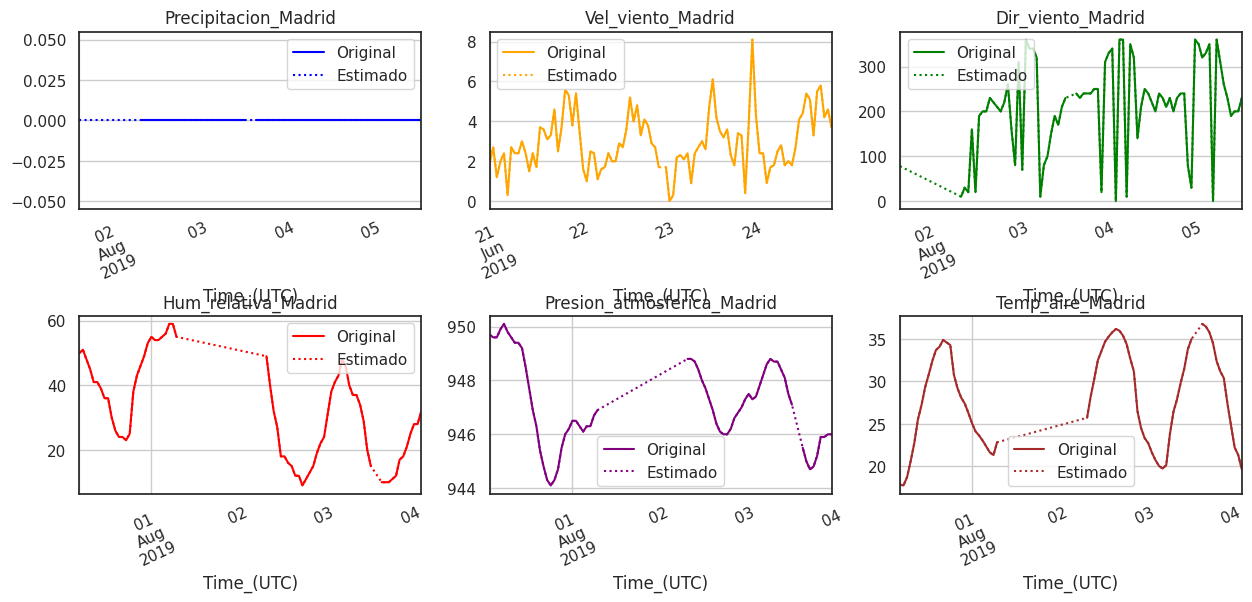

In [ ]:
fig = plt.figure(figsize=(15,6))
fig.subplots_adjust(hspace=0.6, wspace=0.2)
i=1
for c in range(1,7):
  n = np.where(train_original.iloc[:,c].isnull())[0][75]
  ax = fig.add_subplot(2, 3, i)
  train_original.iloc[n-48:n+48,c].plot(color=colores[i-1], rot = 25,label='Original')
  train.iloc[n-48:n+48,c].plot(color=colores[i-1], rot = 25, label='Estimado', linestyle = ":")
  ax.set_title(train.columns[c])
  plt.legend()
  plt.grid()
  i+=1

Este método funciona bien para cuando hay periodos cortos de datos ausentes (menores a 6h), sin embargo, en espacios más largos de tiempo estamos eliminando la característica periódica de las variables climáticas. Gráficamente observamos que una buena aproximación para este caso es repetir los valores del día anterior, con lo que tenemos.

In [ ]:
for i in range(0,len(filas)):
  p=6
  cont = train_original.iloc[filas[i]-p:filas[i]+p+1,columnas[i]].isna().sum()
  if cont>p:
    train.iloc[filas[i],columnas[i]] = np.nan
while train.isna().any().any() == True:
  train = train.fillna(train.shift(24))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



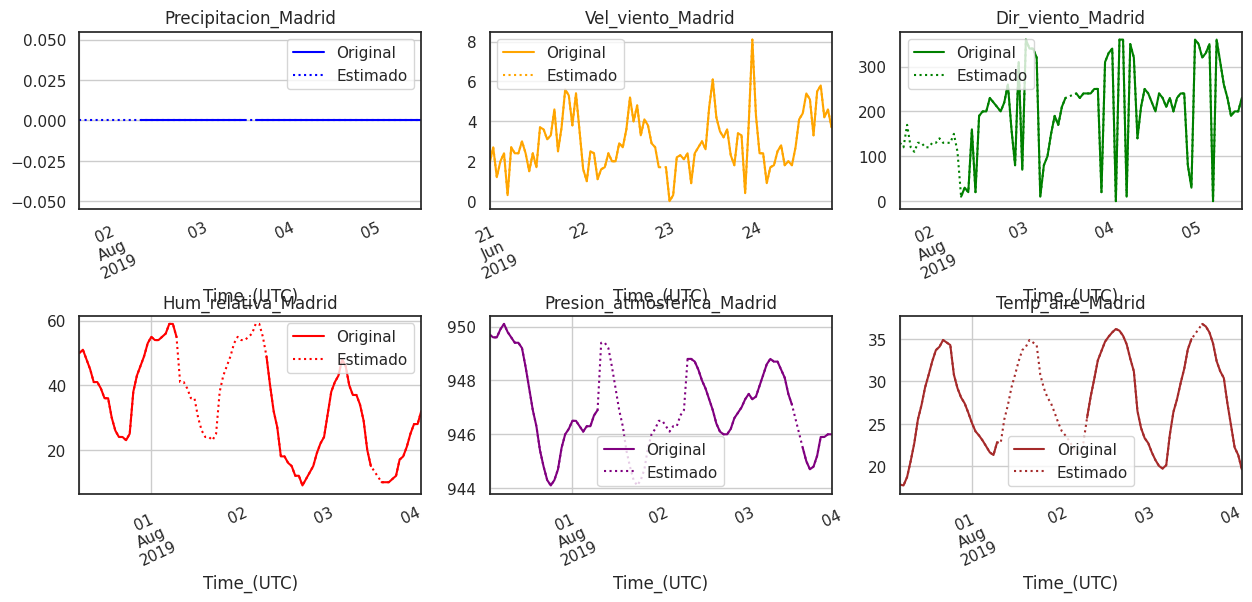

In [ ]:
fig = plt.figure(figsize= (15,6))
fig.subplots_adjust(hspace=0.6, wspace=0.2)
i=1
for c in range(1,7):
  n = np.where(train_original.iloc[:,c].isnull())[0][75]
  ax = fig.add_subplot(2, 3, i)
  train_original.iloc[n-48:n+48,c].plot(color=colores[i-1], rot = 25,label='Original')
  train.iloc[n-48:n+48,c].plot(color=colores[i-1], rot = 25, label='Estimado', linestyle = ":")
  ax.set_title(train.columns[c])
  plt.legend()
  plt.grid()
  i+=1

Los resultados son satisfactorios, por lo tanto, expandimos la estrategia al total de los datos.

In [ ]:
datos_original=datos.copy()
a = np.where(datos_original.isnull())
filas = a[0]
columnas = a[1]
datos = datos.interpolate(method='linear', axis =0)
for i in range(0,len(filas)):
  p=6
  cont = datos_original.iloc[filas[i]-p:filas[i]+p+1,columnas[i]].isna().sum()
  if cont>p:
    datos.iloc[filas[i],columnas[i]] = np.nan
while datos.isna().any().any() == True:
  datos = datos.fillna(datos.shift(24))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Comprobamos que el tratamiento de nulos fue exitoso a lo largo de la serie temporal.

In [ ]:
for column in datos.columns:
    num_nulls = datos[column].isna().sum()
    print(f'Columna "{column}" tiene {num_nulls} nulos')

Columna "Actual_load" tiene 0 nulos
Columna "Precipitacion_Madrid" tiene 0 nulos
Columna "Vel_viento_Madrid" tiene 0 nulos
Columna "Dir_viento_Madrid" tiene 0 nulos
Columna "Hum_relativa_Madrid" tiene 0 nulos
Columna "Presion_atmosferica_Madrid" tiene 0 nulos
Columna "Temp_aire_Madrid" tiene 0 nulos
Columna "Precipitacion_Barcelona" tiene 0 nulos
Columna "Vel_viento_Barcelona" tiene 0 nulos
Columna "Dir_viento_Barcelona" tiene 0 nulos
Columna "Hum_relativa_Barcelona" tiene 0 nulos
Columna "Presion_atmosferica_Barcelona" tiene 0 nulos
Columna "Temp_aire_Barcelona" tiene 0 nulos
Columna "Precipitacion_Valencia" tiene 0 nulos
Columna "Vel_viento_Valencia" tiene 0 nulos
Columna "Dir_viento_Valencia" tiene 0 nulos
Columna "Hum_relativa_Valencia" tiene 0 nulos
Columna "Presion_atmosferica_Valencia" tiene 0 nulos
Columna "Temp_aire_Valencia" tiene 0 nulos


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



A continuación se muestran las características estadísticas del conjunto de entrenamiento.

In [ ]:
train.describe().transpose()

count          mean          std      min  \
Actual_load                    33960.0  27485.956125  4401.717090  16144.0   
Precipitacion_Madrid           33960.0      0.044554     0.390345      0.0   
Vel_viento_Madrid              33960.0      2.839122     2.043029      0.0   
Dir_viento_Madrid              33960.0    203.266343   112.925978      0.0   
Hum_relativa_Madrid            33960.0     58.422659    24.567152      6.0   
Presion_atmosferica_Madrid     33960.0    950.291486     5.748040    925.0   
Temp_aire_Madrid               33960.0     15.903519     9.251214    -12.6   
Precipitacion_Barcelona        33960.0      0.067375     0.883290      0.0   
Vel_viento_Barcelona           33960.0      4.155197     2.232030      0.0   
Dir_viento_Barcelona           33960.0    191.663280   124.346974      0.0   
Hum_relativa_Barcelona         33960.0     71.118939    13.712865     11.0   
Presion_atmosferica_Barcelona  33960.0   1016.477553     6.627464    988.7   
Temp_aire_Barcelona            33960.0     17.854042     6.560602     -0.4   
Precipitacion_Valencia         33960.0      0.060191     0.761701      0.0   
Vel_viento_Valencia            33960.0      3.457716     2.220051      0.0   
Dir_viento_Valencia            33960.0    199.062868   103.466282      0.0   
Hum_relativa_Valencia          33960.0     66.642020    19.099307      8.0   
Presion_atmosferica_Valencia   33960.0   1010.062459     6.210819    984.3   
Temp_aire_Valencia             33960.0     18.518376     7.207437     -1.9   

                                   25%      50%      75%      max  
Actual_load                    23892.0  27543.0  30849.0  41754.0  
Precipitacion_Madrid               0.0      0.0      0.0     17.4  
Vel_viento_Madrid                  1.4      2.2      3.8     17.0  
Dir_viento_Madrid                120.0    210.0    320.0    360.0  
Hum_relativa_Madrid               38.0     59.0     81.0    100.0  
Presion_atmosferica_Madrid       946.8    950.0    953.9    966.3  
Temp_aire_Madrid                   9.1     14.7     22.4     42.4  
Precipitacion_Barcelona            0.0      0.0      0.0     52.7  
Vel_viento_Barcelona               2.7      3.8      5.2     20.6  
Dir_viento_Barcelona              80.0    220.0    310.0    360.0  
Hum_relativa_Barcelona            62.0     73.0     82.0    100.0  
Presion_atmosferica_Barcelona   1012.8   1016.2   1020.5   1036.5  
Temp_aire_Barcelona               12.8     17.3     23.4     34.4  
Precipitacion_Valencia             0.0      0.0      0.0     56.4  
Vel_viento_Valencia                1.9      2.9      4.6     19.9  
Dir_viento_Valencia               90.0    240.0    290.0    360.0  
Hum_relativa_Valencia             53.0     68.0     83.0    100.0  
Presion_atmosferica_Valencia    1006.3   1009.7   1013.9   1029.3  
Temp_aire_Valencia                13.1     18.4     24.0     42.0

Lo primero a notar es que la media y mediana del consumo de energía, prácticamente coinciden alrededor de los 27500 MWh, lo que nos da fuertes indicios de normalidad en esta variable. Para visualizar mejor la distribución de los datos, vamos a dibujar el histograma de la demanda de energía en España.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Text(0.5, 1.0, 'Demanda (MWh)')

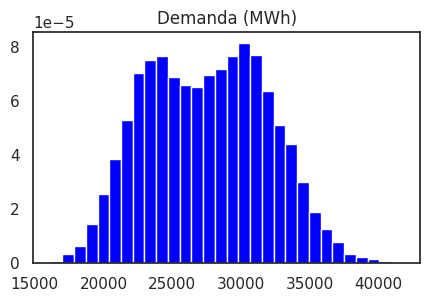

In [ ]:
fig = plt.figure(figsize= (5,3))
ax = fig.add_subplot()
ax.hist(train.iloc[:,0], bins=30, color=colores[0], density=True)
ax.set_title("Demanda (MWh)")

Ahora analizamos los datos meteorológicos, se los compara por ciudad.

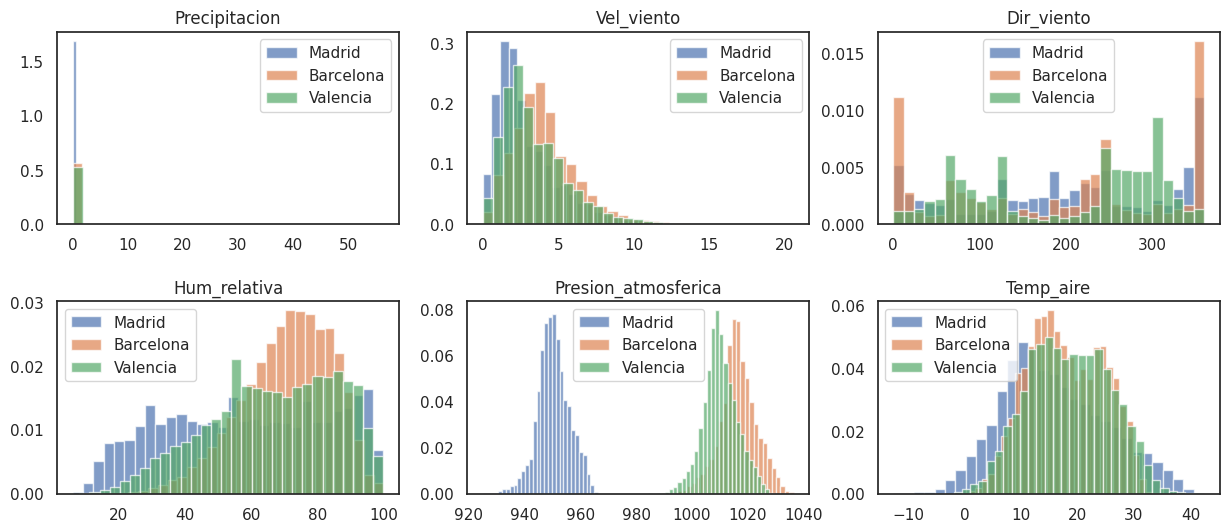

In [ ]:
fig = plt.figure(figsize= (15,6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
i=1
for d in range(1,7):
  ax = fig.add_subplot(2, 3, i)
  ax.hist(train.iloc[:,d], bins=30, alpha=0.7, density=True, label='Madrid')
  ax.hist(train.iloc[:,d+6], bins=30, alpha=0.7, density=True, label='Barcelona')
  ax.hist(train.iloc[:,d+12], bins=30, alpha=0.7, density=True, label='Valencia')
  plt.legend()
  ax.set_title(train.columns[d][:-7])
  i+=1

Los valores se ven homogéneamente distribuidos y no se detecta ningún outlier a simple vista, la variable precipitación muestra baja varianza, esto es contraproducente para el problema a tratar, ya que las variables con varianzas muy bajas aportan poca o ninguna información relevante para los modelos predictivos. A continuación se comparan las varianzas del conjunto de datos normalizado, se ve claramente que la variable precipitación aloja los datos con menor varianza.

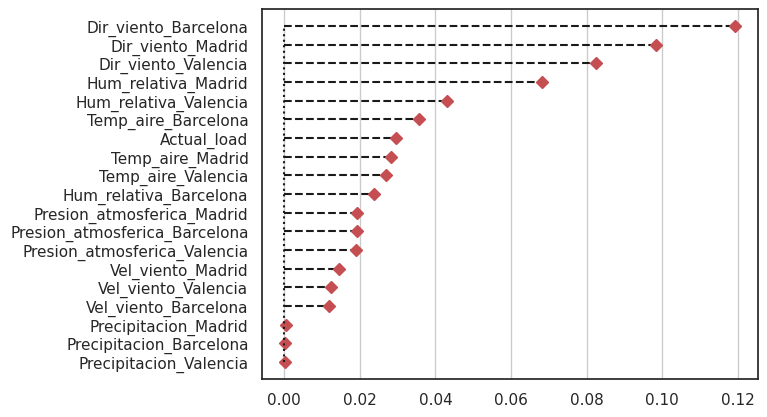

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#Normalizar las características
scaler = MinMaxScaler()
df_standardized = scaler.fit_transform(train)
df_standardized = pd.DataFrame(df_standardized, columns=train.columns)
R=df_standardized.var().sort_values(ascending=True)
plt.stem(R.index,R,orientation = "horizontal",linefmt = 'k--',markerfmt = 'Dr',basefmt = 'k:')
plt.grid(axis = "x")

## Análisis de la serie de tiempo

Se gráfican los valores de demanda eléctrica en diferentes escalas de tiempo para  observar patrones de tendencia o estacionalidad en el tiempo.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



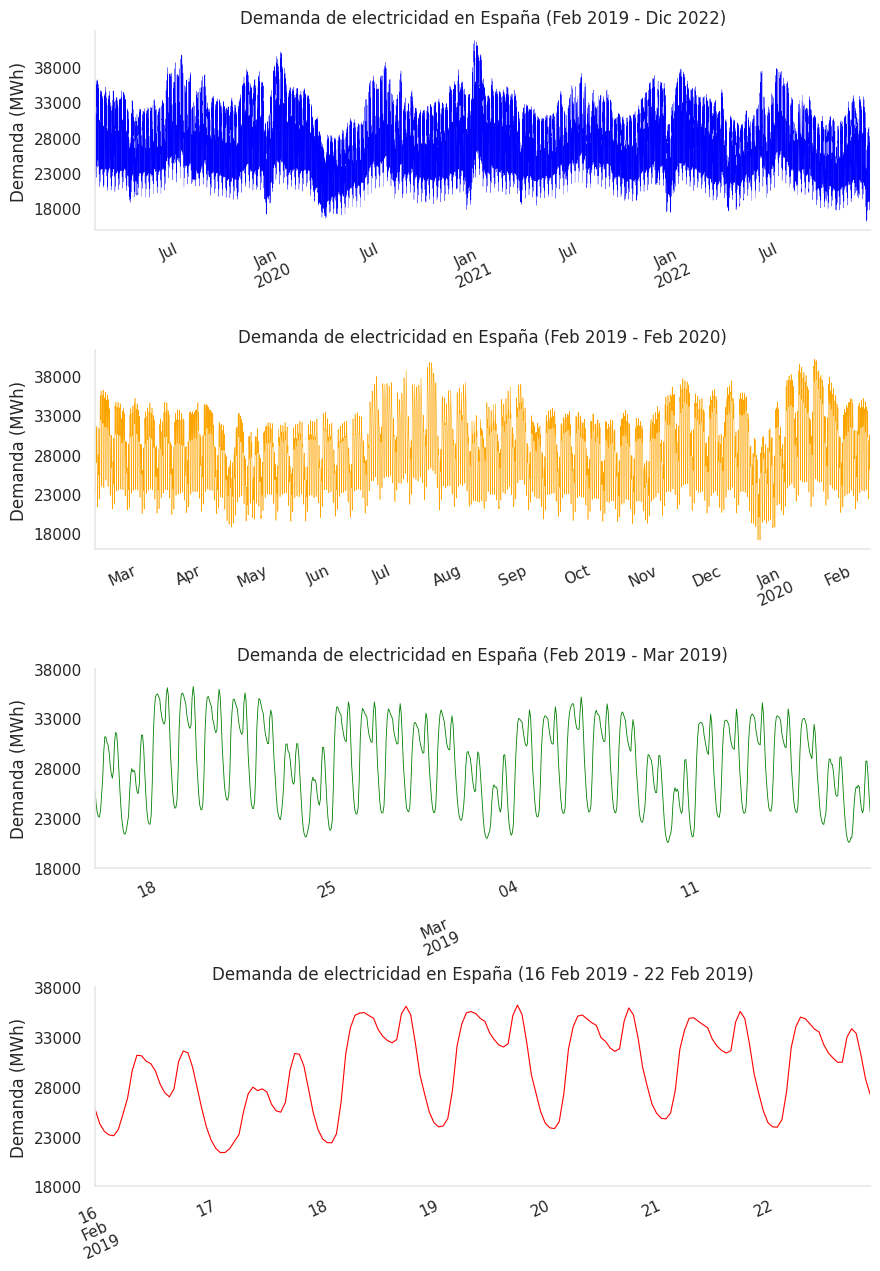

In [ ]:
titulos = ["(Feb 2019 - Dic 2022)","(Feb 2019 - Feb 2020)","(Feb 2019 - Mar 2019)","(16 Feb 2019 - 22 Feb 2019)"]
fechas = [len(train),24*365,24*30,24*7]
fig = plt.figure(figsize=(10, 15))
fig.subplots_adjust(hspace=0.6, wspace=0.3)
for i in range(1,5):
  ax = fig.add_subplot(4, 1, i)
  ts = train.iloc[:fechas[i-1],0]
  ts.plot(color=colores[i-1], rot = 25, linewidth=0.2*i)
  ax.set_title("Demanda de electricidad en España " + titulos[i-1])
  ax.set_yticks([y for y in np.arange(18000, 41000, 5000)])
  ax.spines["left"].set_color("#e8e8e8")
  ax.spines["bottom"].set_color("#e8e8e8")
  ax.spines["right"].set_color("none")
  ax.spines["top"].set_color("none")
  plt.ylabel('Demanda (MWh)')
  plt.xlabel('')

De los graficos podemos extraer algunas conclusiones respecto a la tendencia y estacionalidad:
1. No se observa tendencia.
2. Hay estacionalidad semanal.
3. Hay estacionalidad diaria.

Por último vamos a ver los gráficos de autocorrelación para retardos diarios y semanales.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



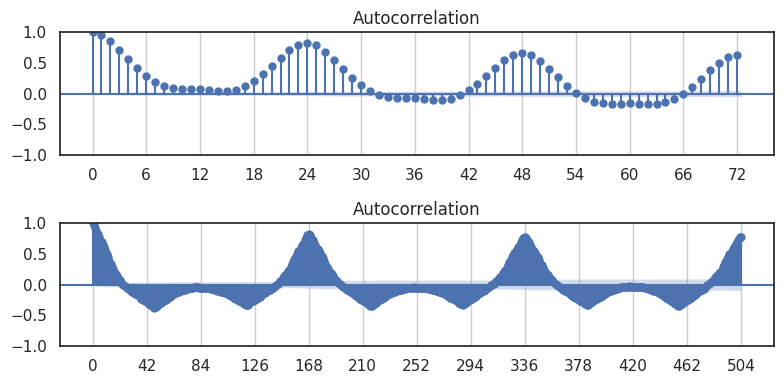

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 4))
plot_acf(train['Actual_load'], lags=24*3, ax=ax1)
ax1.set_xticks([x for x in np.arange(0, 24*3+1, 6)])
ax1.grid(axis = "x")
x = train['Actual_load'].diff(24).dropna()
plot_acf(x, lags=24*7*3, ax=ax2)
ax2.set_xticks([x for x in np.arange(0, 24*7*3+1, 42)])
ax2.grid(axis = "x")
plt.tight_layout()
plt.show()

 Se comprueba que la serie de tiempo tiene estacionalidad de 24 horas y 7 días.

## Ingeniería de características


Empecemos por analizar la variable dirección del viento, se trata de valores angulares (0-360), que es un tipo de dato incompatible con los modelos de ML, por lo que vamos a realizar una transformación a coordenadas cartesianas.


In [ ]:
for x in ["Madrid", "Barcelona", "Valencia"]:
  train['Viento_x_'+x] = train["Vel_viento_"+x]*np.cos(2*np.pi*train["Dir_viento_"+x]/360)
  train['Viento_y_'+x] = train["Vel_viento_"+x]*np.sin(2*np.pi*train["Dir_viento_"+x]/360)
  train.drop(["Vel_viento_"+x,"Dir_viento_"+x], axis = 1, inplace = True)

Replicamos en todos los datos.

In [ ]:
for x in ["Madrid", "Barcelona", "Valencia"]:
  datos['Viento_x_'+x] = datos["Vel_viento_"+x]*np.cos(2*np.pi*datos["Dir_viento_"+x]/360)
  datos['Viento_y_'+x] = datos["Vel_viento_"+x]*np.sin(2*np.pi*datos["Dir_viento_"+x]/360)
  datos.drop(["Vel_viento_"+x,"Dir_viento_"+x], axis = 1, inplace = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



En el análisis exploratorio vimos que la precipitación es una magnitud con baja varianza y es mejor desecharla del estudio.

In [ ]:
train.drop(["Precipitacion_Valencia","Precipitacion_Madrid","Precipitacion_Barcelona"], axis = 1, inplace = True)
datos.drop(["Precipitacion_Valencia","Precipitacion_Madrid","Precipitacion_Barcelona"], axis = 1, inplace = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Dibujamos la matriz de correlación entre los predictores y la variable objetivo.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<Axes: >

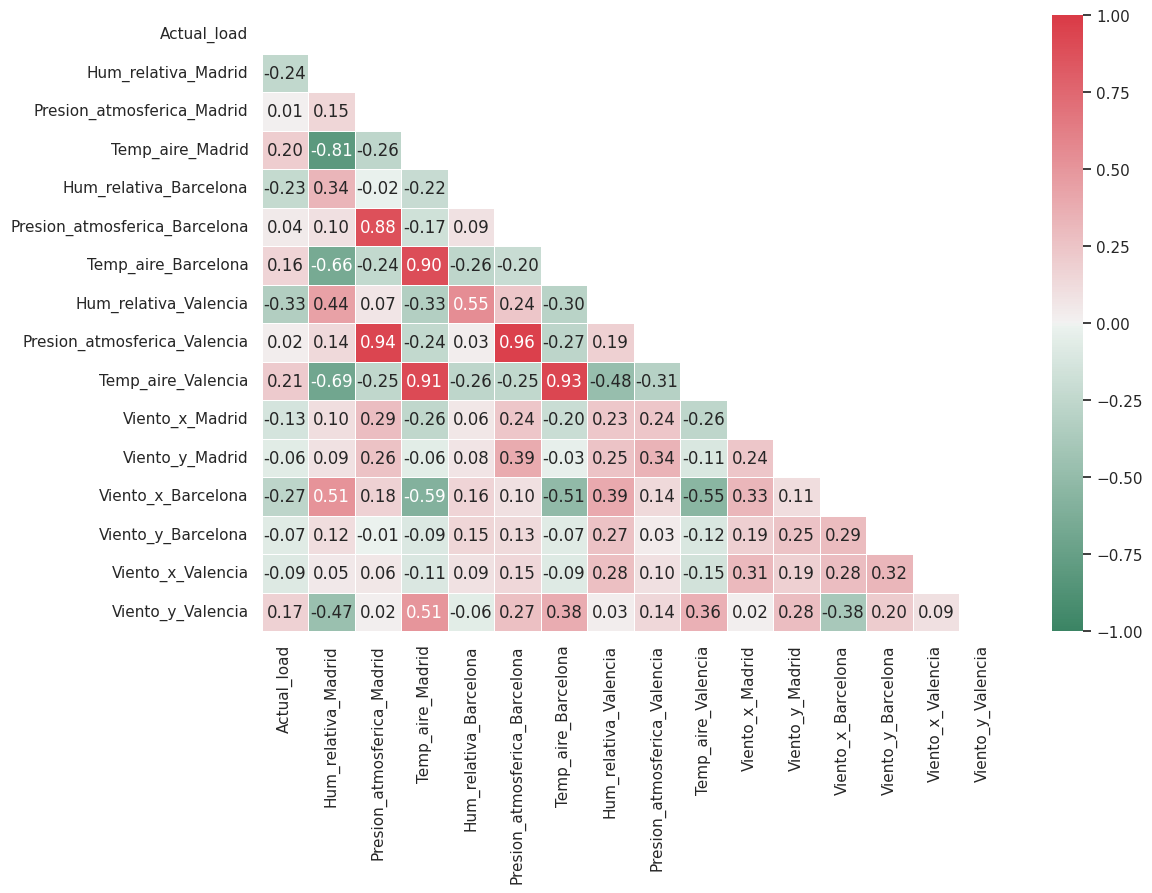

In [ ]:
R = train.corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.set(style="white")
mask = np.zeros_like(R, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(150, 10, as_cmap=True)
sns.heatmap(R, mask=mask, vmin=-1, vmax=1, cmap=cmap, annot=True, fmt='.2f', linewidths=.5)

No existe correlación importante entre "Actual_load" y ninguno de los predictores debido a que el problema no es lineal, pero vemos zonas de alta correlación entre variables climáticas. Con el objetivo de prevenir multicolinealidad y reducir dimensiones, se crea un nuevo conjunto de variables climáticas que capten las características de las 3 ciudades tomadas en cuenta en ese estudio. Además de los valores originales del dataset, se añaden el promedio y promedio ponderado por tamaño de la población como candidatos y se elige el que tenga más correlación con la variable objetivo.


In [ ]:
m, b, v = 3266126, 1636762, 794288
total = m + b + v
train["Hum_relativa_pond"] = (m*train["Hum_relativa_Madrid"]+b*train["Hum_relativa_Barcelona"]+v*train["Hum_relativa_Valencia"])/total
train["Presion_atm_pond"]  = (m*train["Presion_atmosferica_Madrid"]+b*train["Presion_atmosferica_Barcelona"]+v*train["Presion_atmosferica_Valencia"])/total
train["Temp_aire_pond"]    = (m*train["Temp_aire_Madrid"]+b*train["Temp_aire_Barcelona"]+v*train["Temp_aire_Valencia"])/total
train["Viento_x_pond"]     = (m*train["Viento_x_Madrid"]+b*train["Viento_x_Barcelona"]+v*train["Viento_x_Valencia"])/total
train["Viento_y_pond"]     = (m*train["Viento_y_Madrid"]+b*train["Viento_y_Barcelona"]+v*train["Viento_y_Valencia"])/total

train["Hum_relativa_prom"] = (train["Hum_relativa_Madrid"]+train["Hum_relativa_Barcelona"]+train["Hum_relativa_Valencia"])/3
train["Presion_atm_prom"]  = (train["Presion_atmosferica_Madrid"]+train["Presion_atmosferica_Barcelona"]+train["Presion_atmosferica_Valencia"])/3
train["Temp_aire_prom"]    = (train["Temp_aire_Madrid"]+train["Temp_aire_Barcelona"]+train["Temp_aire_Valencia"])/3
train["Viento_x_prom"]     = (train["Viento_x_Madrid"]+train["Viento_x_Barcelona"]+train["Viento_x_Valencia"])/3
train["Viento_y_prom"]     = (train["Viento_y_Madrid"]+train["Viento_y_Barcelona"]+train["Viento_y_Valencia"])/3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Se muestran las medias de los índices de correlación ordenados de mayor a menor para cada candidato.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



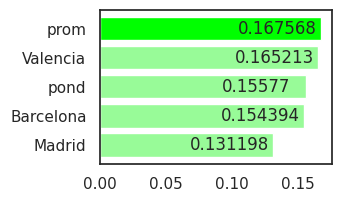

In [ ]:
R = abs(train.corr())
R = R.iloc[1:,0:1]
R["Grupo"] = R.index
R['Grupo'] = R["Grupo"].apply(lambda x: x.split('_')[-1])
R = R.groupby('Grupo').mean()["Actual_load"].sort_values(ascending=True)
plt.figure(figsize=(3, 2))
graf = plt.barh(R.index, R, color=["palegreen","palegreen","palegreen","palegreen","lime"])
plt.bar_label(graf, padding=-60)
plt.show()

Se ve que el valor más alto corresponde al promedio de las variables climáticas de Madrid, Barcelona y Valencia.

In [ ]:
train.drop(train.iloc[:,1:21].columns, axis = 1, inplace = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
datos["Hum_relativa_prom"] = (datos["Hum_relativa_Madrid"]+datos["Hum_relativa_Barcelona"]+datos["Hum_relativa_Valencia"])/3
datos["Presion_atm_prom"]  = (datos["Presion_atmosferica_Madrid"]+datos["Presion_atmosferica_Barcelona"]+datos["Presion_atmosferica_Valencia"])/3
datos["Temp_aire_prom"]    = (datos["Temp_aire_Madrid"]+datos["Temp_aire_Barcelona"]+datos["Temp_aire_Valencia"])/3
datos["Viento_x_prom"]     = (datos["Viento_x_Madrid"]+datos["Viento_x_Barcelona"]+datos["Viento_x_Valencia"])/3
datos["Viento_y_prom"]     = (datos["Viento_y_Madrid"]+datos["Viento_y_Barcelona"]+datos["Viento_y_Valencia"])/3
datos.drop(datos.iloc[:,1:16].columns, axis = 1, inplace = True)

Del análisis de la serie de tiempo sabemos que la demanda de energía en España tiene estacionalidad de 24 horas y 7 días, por lo tanto, incluímos las trasformaciones senoidales y cosenoidales de la hora y el día de la semana, esto porque así se expresa de mejor manera la relación periódica del tiempo con el problema de demanda de energía.

In [ ]:
hora = train.index.hour
dia = 24*train.index.weekday + hora
train['sin_hora'] = np.sin(2*np.pi*hora/24)
train['cos_hora'] = np.cos(2*np.pi*hora/24)
train['sin_dia'] = np.sin(2*np.pi*dia/(24*7))
train['cos_dia'] = np.cos(2*np.pi*dia/(24*7))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
hora = datos.index.hour
dia = 24*datos.index.weekday + hora
datos['sin_hora'] = np.sin(2*np.pi*hora/24)
datos['cos_hora'] = np.cos(2*np.pi*hora/24)
datos['sin_dia'] = np.sin(2*np.pi*dia/(24*7))
datos['cos_dia'] = np.cos(2*np.pi*dia/(24*7))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Ahora se tiene un conjunto de predictores más pequeño pero más robusto, lo comprobamos con la matriz de correlación.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<Axes: >

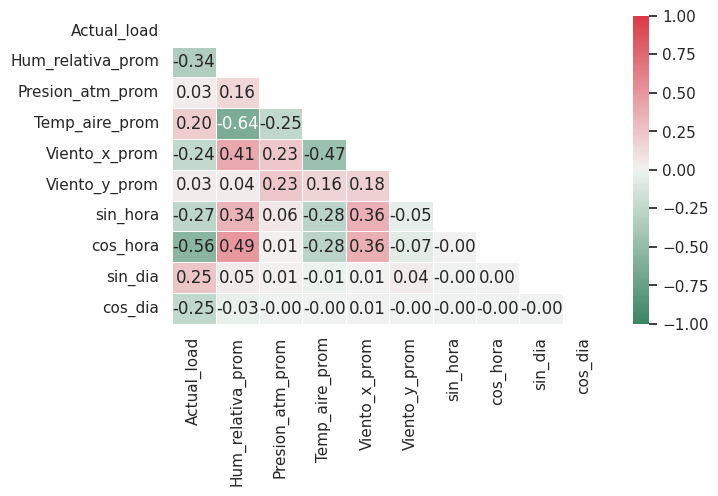

In [ ]:
R = train.corr()
f, ax = plt.subplots(figsize=(7, 4))
sns.set(style="white")
mask = np.zeros_like(R, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(150, 10, as_cmap=True)
sns.heatmap(R, mask=mask, vmin=-1, vmax=1, cmap=cmap, annot=True, fmt='.2f', linewidths=.5)

Finalmente separamos la variable objetivo de los predictores.

In [ ]:
x_datos = datos.iloc[:,1:]
y_datos = datos['Actual_load']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



---
# Predicción
---

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

!pip install skforecast
import skforecast
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import random_search_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster

import xgboost as xgb
from xgboost import plot_importance, plot_tree

import lightgbm
from lightgbm import LGBMRegressor

metricas = [ 'mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error']
rmse_val = [0,0,0,0]
rmse_test = [0,0,0,0]
mae_val = [0,0,0,0]
mae_test = [0,0,0,0]
mape_val = [0,0,0,0]
mape_test = [0,0,0,0]
nrmse_val = [0,0,0,0]
nrmse_test = [0,0,0,0]
sin_exog = [0,0,0,0]
prediccion = [y_datos[fin_val:]]*4


##Modelo Base

El modelo base es un modelo simple para la predicción de demanda, así podemos establecer comparaciones con los modelos de ML y saber si vale la pena desarrollar modelos más complejos. Como métrica de evaluación se utilizará el error medio absoluto o MAE.
El análisis exploratorio indicó la existencia de estacionalidad en el comportamiento de la demanda de energía, así que podemos predecir los valores futuros tan solo repitiendo los valores pasados, evaluamos el rendimiento del modelo repitiendo desde 1 día hasta 30 días atrás y vemos que el menor error se da a los 7 días.

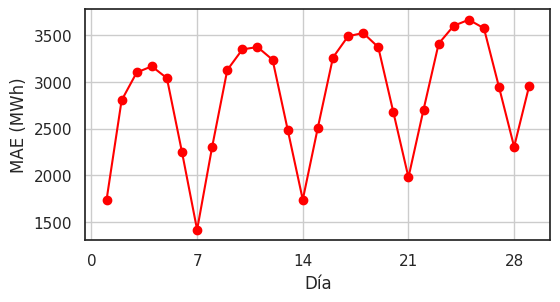

In [ ]:
df = pd.DataFrame()
steps = 24
n_trials = 20
for i in range(1,30):
  baseline = ForecasterEquivalentDate(
                  offset    = pd.DateOffset(days=i),
                  n_offsets = 1
              )
  #Validacion
  mae, pred = backtesting_forecaster(
                                      forecaster         = baseline,
                                      y                  = y_datos[:fin_val],
                                      initial_train_size = len(y_datos[:fin_train]),
                                      fixed_train_size   = True,
                                      steps              = steps,
                                      refit              = False,
                                      metric             = metricas,
                                      n_jobs             = 'auto',
                                      verbose            = False,
                                      show_progress      = False
                                  )
  df = pd.concat([df, mae], axis=0)
error        = df.sort_values(by = "mean_absolute_error", ascending=True)
rmse_val[0]  = np.sqrt(error.iloc[0,1])
nrmse_val[0] = 100*np.sqrt(error.iloc[0,1])/(max(y_datos[fin_val:])-min(y_datos[fin_val:]))
mae_val[0]   = error.iloc[0,0]
mape_val[0]  = 100*error.iloc[0,2]

fig, ax = plt.subplots(figsize=(6, 3))
ax.set_xlabel('Día')
ax.set_ylabel('MAE (MWh)')
ax.plot(range(1,30), df["mean_absolute_error"], marker='o', color="red")
plt.xticks(range(0,30,7))
ax.grid(True)

In [ ]:
#Elegimos el valor de menor mae para el modelo base final
baseline = ForecasterEquivalentDate(
                offset    = pd.DateOffset(days=1+np.argmin(df["mean_absolute_error"])),
                n_offsets = 1
            )
#Test
error, pred = backtesting_forecaster(
                                    forecaster         = baseline,
                                    y                  = y_datos,
                                    initial_train_size = len(y_datos[:fin_val]),
                                    fixed_train_size   = True,
                                    steps              = steps,
                                    refit              = False,
                                    metric             = metricas,
                                    n_jobs             = 'auto',
                                    verbose            = False
                                 )
rmse_test[0]  = np.sqrt(error.iloc[0,1])
nrmse_test[0] = 100*np.sqrt(error.iloc[0,1])/(max(y_datos[fin_val:])-min(y_datos[fin_val:]))
mae_test[0]   = error.iloc[0,0]
mape_test[0]  = 100*error.iloc[0,2]
sin_exog[0]   = mae_test[0]
prediccion[0] = pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/182 [00:00<?, ?it/s]

##Random forest

Utilizamos el algoritmo random forest con los parámetros por defecto y lo evaluamos utilizando la técnica backtesting en el conjunto de validación, el horizonte de predicción es un día.

In [ ]:
rforest = ForecasterAutoreg(
      regressor        = RandomForestRegressor(random_state=seed),
      transformer_y    = StandardScaler(),
      transformer_exog = StandardScaler(),
      lags             = 24
)
mae, pred = backtesting_forecaster(
                                    forecaster         = rforest,
                                    y                  = y_datos[:fin_val],
                                    exog               = x_datos[:fin_val],
                                    initial_train_size = len(y_datos[:fin_train]),
                                    fixed_train_size   = True,
                                    steps              = steps,
                                    refit              = False,
                                    metric             = 'mean_absolute_error',
                                    n_jobs             = 'auto',
                                    verbose            = False
                                    )
print("MAE = " + str(mae.iloc[0,0]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/365 [00:00<?, ?it/s]

MAE = 1208.292350456621


Se utiliza la estrategia de optimización bayesiana para encontrar los mejores hiperparámetros y obtener mejores resultados.

In [ ]:
#Optimizacion por bayesian search
lags = [24,48]
def search_space(param):
    parametros  = {
        'n_estimators'     : param.suggest_int('n_estimators', 50, 400, step=50),
        'max_depth'        : param.suggest_int('max_depth', 5, 20, step=1),
        'max_features'     : param.suggest_int('max_features', 3 , 20, step=1),
        'min_samples_leaf' : param.suggest_int('min_samples_leaf', 1 , 10, step=1),
        'min_samples_split': param.suggest_int('min_samples_split', 2 , 10, step=1),
        'lags'             : param.suggest_categorical('lags', lags)
    }
    return parametros
res_bayes = bayesian_search_forecaster(
                                        forecaster         = rforest,
                                        y                  = y_datos[:fin_val],
                                        exog               = x_datos[:fin_val],
                                        steps              = steps,
                                        metric             = metricas,
                                        search_space       = search_space,
                                        initial_train_size = len(y_datos[:fin_train]),
                                        refit              = False,
                                        n_trials           = n_trials,
                                        random_state       = seed,
                                        return_best        = True,
                                        n_jobs             = 'auto',
                                        verbose            = False,
                                        show_progress      = True
                                    )
error        = res_bayes[0].sort_values(by = "mean_absolute_error", ascending=True)
rmse_val[1]  = np.sqrt(error.iloc[0,3])
nrmse_val[1] = 100*np.sqrt(error.iloc[0,3])/(max(y_datos[fin_val:])-min(y_datos[fin_val:]))
mae_val[1]   = error.iloc[0,2]
mape_val[1]  = 100*error.iloc[0,4]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 250, 'max_depth': 14, 'max_features': 16, 'min_samples_leaf': 1, 'min_samples_split': 7}
  Backtesting metric: 855.5096948494573



In [ ]:
#Test sin variables exogenas
error, pred = backtesting_forecaster(
                                    forecaster         = rforest,
                                    y                  = y_datos,
                                    initial_train_size = len(y_datos[:fin_val]),
                                    fixed_train_size   = True,
                                    steps              = steps,
                                    refit              = False,
                                    metric             = metricas,
                                    n_jobs             = 'auto',
                                    verbose            = False
                                 )
sin_exog[1]   = error.iloc[0,0]

#Test
error, pred = backtesting_forecaster(
                                    forecaster         = rforest,
                                    y                  = y_datos,
                                    exog               = x_datos,
                                    initial_train_size = len(y_datos[:fin_val]),
                                    fixed_train_size   = True,
                                    steps              = steps,
                                    refit              = False,
                                    metric             = metricas,
                                    n_jobs             = 'auto',
                                    verbose            = False
                                 )
rmse_test[1]  = np.sqrt(error.iloc[0,1])
nrmse_test[1] = 100*np.sqrt(error.iloc[0,1])/(max(y_datos[fin_val:])-min(y_datos[fin_val:]))
mae_test[1]   = error.iloc[0,0]
mape_test[1]  = 100*error.iloc[0,2]
prediccion[1] = pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

##XGBoost

Desarrollamos otro tipo de algoritmo de ML y procedemos igual que en el caso anterior.

In [273]:
xgboost = ForecasterAutoreg(
    regressor        = xgb.XGBRegressor(random_state=seed),
    transformer_y    = StandardScaler(),
    transformer_exog = StandardScaler(),
    lags             = 24
)
mae, pred = backtesting_forecaster(
                                    forecaster         = xgboost,
                                    y                  = y_datos[:fin_val],
                                    exog               = x_datos[:fin_val],
                                    initial_train_size = len(y_datos[:fin_train]),
                                    fixed_train_size   = True,
                                    steps              = steps,
                                    refit              = False,
                                    metric             = 'mean_absolute_error',
                                    n_jobs             = 'auto',
                                    verbose            = False
                                    )
print("MAE = " + str(mae.iloc[0,0]))

  0%|          | 0/365 [00:00<?, ?it/s]

MAE = 1012.650556047406


In [274]:
#Optimizacion por bayesian search
lags = [24,48]
def search_space(param):
    parametros  = {
        'n_estimators'     : param.suggest_int('n_estimators', 100, 1000, step=50),
        'max_depth'        : param.suggest_int('max_depth', 5, 20, step=1),
        'min_child_weight' : param.suggest_int('min_child_weight', 1 , 10, step=1),
        'colsample_bytree' : param.suggest_float('colsample_bytree', 0.5, 1, step=0.1),
        'eta'              : param.suggest_float('eta', 0.001, 0.1),
        'reg_alpha'       : param.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : param.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'             : param.suggest_categorical('lags', lags)
    }
    return parametros
res_bayes = bayesian_search_forecaster(
                                        forecaster         = xgboost,
                                        y                  = y_datos[:fin_val],
                                        exog               = x_datos[:fin_val],
                                        steps              = steps,
                                        metric             = metricas,
                                        search_space       = search_space,
                                        initial_train_size = len(y_datos[:fin_train]),
                                        refit              = False,
                                        n_trials           = n_trials,
                                        random_state       = seed,
                                        return_best        = True,
                                        n_jobs             = 'auto',
                                        verbose            = False,
                                        show_progress      = True
                                    )
error        = res_bayes[0].sort_values(by = "mean_absolute_error", ascending=True)
rmse_val[2]  = np.sqrt(error.iloc[0,3])
nrmse_val[2] = 100*np.sqrt(error.iloc[0,3])/(max(y_datos[fin_val:])-min(y_datos[fin_val:]))
mae_val[2]   = error.iloc[0,2]
mape_val[2]  = 100*error.iloc[0,4]

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 850, 'max_depth': 8, 'min_child_weight': 7, 'colsample_bytree': 0.6, 'eta': 0.07131536281495354, 'reg_alpha': 0.2, 'reg_lambda': 0.7000000000000001}
  Backtesting metric: 753.4052886466565



In [275]:
#Test sin variables exogenas
error, pred = backtesting_forecaster(
                                    forecaster         = xgboost,
                                    y                  = y_datos,
                                    initial_train_size = len(y_datos[:fin_val]),
                                    fixed_train_size   = True,
                                    steps              = steps,
                                    refit              = False,
                                    metric             = metricas,
                                    n_jobs             = 'auto',
                                    verbose            = False
                                 )
sin_exog[2]   = error.iloc[0,0]

#Test
error, pred = backtesting_forecaster(
                                    forecaster         = xgboost,
                                    y                  = y_datos,
                                    exog               = x_datos,
                                    initial_train_size = len(y_datos[:fin_val]),
                                    fixed_train_size   = True,
                                    steps              = steps,
                                    refit              = False,
                                    metric             = metricas,
                                    n_jobs             = 'auto',
                                    verbose            = False
                                 )
rmse_test[2] = np.sqrt(error.iloc[0,1])
nrmse_test[2] = 100*np.sqrt(error.iloc[0,1])/(max(y_datos[fin_val:])-min(y_datos[fin_val:]))
mae_test[2] = error.iloc[0,0]
mape_test[2] = 100*error.iloc[0,2]
prediccion[2] = pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

##LightGBM

Desarrollamos un tercer algoritmo para establecer una comparativa extensa.

In [276]:
lightgbm = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=seed, verbose=-1),
    transformer_y    = StandardScaler(),
    transformer_exog = StandardScaler(),
    lags             = 24
)
mae, pred = backtesting_forecaster(
                                    forecaster         = lightgbm,
                                    y                  = y_datos[:fin_val],
                                    exog               = x_datos[:fin_val],
                                    initial_train_size = len(y_datos[:fin_train]),
                                    fixed_train_size   = True,
                                    steps              = steps,
                                    refit              = False,
                                    metric             = 'mean_absolute_error',
                                    n_jobs             = 'auto',
                                    verbose            = False
                                    )
print("MAE = " + str(mae.iloc[0,0]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/365 [00:00<?, ?it/s]

MAE = 1057.376397936758


In [277]:
#Optimizacion por bayesian search
lags = [24,48]
def search_space(param):
    parametros  = {

        'n_estimators'    : param.suggest_int('n_estimators', 100, 1000, step=50),
        'max_depth'       : param.suggest_int('max_depth', 5, 20, step=1),
        'min_data_in_leaf': param.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : param.suggest_float('learning_rate', 0.001, 0.1),
        'feature_fraction': param.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : param.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : param.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : param.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'             : param.suggest_categorical('lags', lags)
    }
    return parametros
res_bayes = bayesian_search_forecaster(
                                        forecaster         = lightgbm,
                                        y                  = y_datos[:fin_val],
                                        exog               = x_datos[:fin_val],
                                        steps              = steps,
                                        metric             = metricas,
                                        search_space       = search_space,
                                        initial_train_size = len(y_datos[:fin_train]),
                                        refit              = False,
                                        n_trials           = n_trials,
                                        random_state       = seed,
                                        return_best        = True,
                                        n_jobs             = 'auto',
                                        verbose            = False,
                                        show_progress      = True
                                    )
error = res_bayes[0].sort_values(by = "mean_absolute_error", ascending=True)
rmse_val[3] = np.sqrt(error.iloc[0,3])
nrmse_val[3] = 100*np.sqrt(error.iloc[0,3])/(max(y_datos[fin_val:])-min(y_datos[fin_val:]))
mae_val[3] = error.iloc[0,2]
mape_val[3] = 100*error.iloc[0,4]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 850, 'max_depth': 20, 'min_data_in_leaf': 44, 'learning_rate': 0.08769150076213825, 'feature_fraction': 0.6, 'max_bin': 150, 'reg_alpha': 0.8, 'reg_lambda': 0.7000000000000001}
  Backtesting metric: 770.7695436757867



In [278]:
#Test sin variables exogenas
error, pred = backtesting_forecaster(
                                    forecaster         = lightgbm,
                                    y                  = y_datos,
                                    initial_train_size = len(y_datos[:fin_val]),
                                    fixed_train_size   = True,
                                    steps              = steps,
                                    refit              = False,
                                    metric             = metricas,
                                    n_jobs             = 'auto',
                                    verbose            = False
                                 )
sin_exog[3]   = error.iloc[0,0]

#Test
error, pred = backtesting_forecaster(
                                    forecaster         = lightgbm,
                                    y                  = y_datos,
                                    exog               = x_datos,
                                    initial_train_size = len(y_datos[:fin_val]),
                                    fixed_train_size   = True,
                                    steps              = steps,
                                    refit              = False,
                                    metric             = metricas,
                                    n_jobs             = 'auto',
                                    verbose            = False
                                 )
rmse_test[3] = np.sqrt(error.iloc[0,1])
nrmse_test[3] = 100*np.sqrt(error.iloc[0,1])/(max(y_datos[fin_val:])-min(y_datos[fin_val:]))
mae_test[3] = error.iloc[0,0]
mape_test[3] = 100*error.iloc[0,2]
prediccion[3] = pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

---
# Conclusiones
---

Explicabilidad de los modelos:

In [279]:
a = pd.DataFrame()
for m in [rforest, xgboost, lightgbm]:
  fi = m.get_feature_importances()
  fi = fi.reset_index()
  a = pd.concat([a, fi.head(5)], axis=1)
a

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



index feature  importance  index   feature  importance  index  \
0      0   lag_1    0.405418      0     lag_1    0.328485      0   
1      1   lag_2    0.163267      1     lag_2    0.200436     24   
2     23  lag_24    0.114382     23    lag_24    0.146710     23   
3     22  lag_23    0.070303     54  cos_hora    0.137024     50   
4     24  lag_25    0.049669     53  sin_hora    0.024013     55   

          feature  importance  
0           lag_1        1759  
1          lag_25        1361  
2          lag_24        1300  
3  Temp_aire_prom        1004  
4         sin_dia         796

Teniendo en cuenta solo las variables climáticas:

In [280]:
a = pd.DataFrame()
for m in [rforest, xgboost, lightgbm]:
  fi = m.get_feature_importances().loc[[48,49,50,51,52]].sort_values(by = "importance", ascending=False)
  fi = fi.reset_index()
  a = pd.concat([a, fi.head(5)], axis=1)
a

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



index            feature  importance  index            feature  importance  \
0     50     Temp_aire_prom    0.001078     50     Temp_aire_prom    0.000865   
1     48  Hum_relativa_prom    0.000201     49   Presion_atm_prom    0.000124   
2     49   Presion_atm_prom    0.000181     48  Hum_relativa_prom    0.000116   
3     51      Viento_x_prom    0.000142     51      Viento_x_prom    0.000064   
4     52      Viento_y_prom    0.000129     52      Viento_y_prom    0.000057   

   index            feature  importance  
0     50     Temp_aire_prom        1004  
1     48  Hum_relativa_prom         644  
2     49   Presion_atm_prom         630  
3     52      Viento_y_prom         440  
4     51      Viento_x_prom         378

A continuación vemos un gráfico de barras comparando el rendimiento del modelo base con los métodos más avanzados de machine learning.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



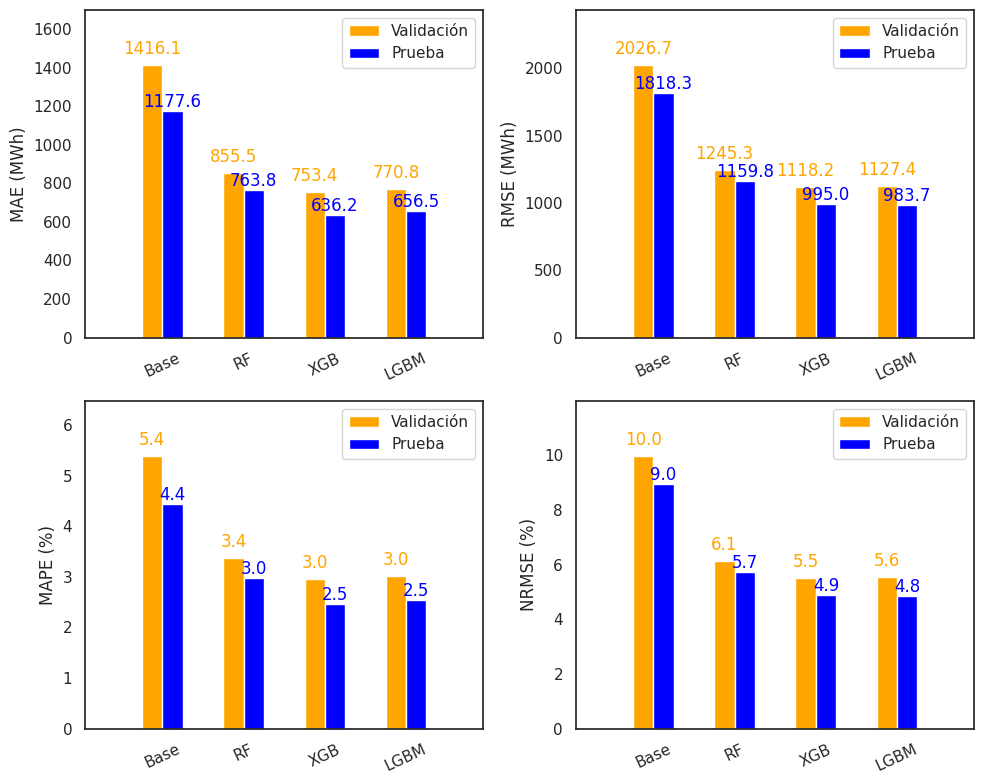

In [281]:
modelos = ['Base', 'RF', 'XGB', 'LGBM']
y = ["MAE (MWh)", "RMSE (MWh)", "MAPE (%)", "NRMSE (%)"]
x = np.arange(len(modelos))
ancho = 0.25
fig, ax = plt.subplots(figsize=(10, 8))
plt.xticks([])
plt.yticks([])
ax.spines["left"].set_color("none")
ax.spines["bottom"].set_color("none")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
i=1
for m in [[mae_val,mae_test], [rmse_val,rmse_test], [mape_val,mape_test], [nrmse_val,nrmse_test]]:
  ax = fig.add_subplot(2, 2, i)
  validacion = ax.bar(x - ancho/2, m[0], ancho, color=colores[1], label='Validación')
  prueba = ax.bar(x + ancho/2, m[1], ancho, color=colores[0], label='Prueba')
  ax.set_ylabel(y[i-1])
  ax.set_xticks(x, modelos, rotation=25)
  ax.margins(x=0.2, y=0.2)
  ax.legend()
  ax.bar_label(validacion, padding=5, color=colores[1], fmt='%.1f')
  ax.bar_label(prueba, padding=0, color=colores[0], fmt='%.1f')
  fig.tight_layout()
  i+=1

plt.show()

En todos los modelos de ML se consiguen mejores resultados que en el modelo base. Ahora comparemos que efecto hubo al utilizar variables exógenas.

In [282]:
pd.DataFrame({"Modelo":["Base", "RF", "XGB","LGBM"], "MAE sin exog":sin_exog, "MAE con exog":mae_test})

Modelo  MAE sin exog  MAE con exog
0   Base   1177.608974   1177.608974
1     RF   1104.467756    763.792410
2    XGB    949.703768    636.179361
3   LGBM   1038.667579    656.502089

A continuación, se grafican las predicciones de los cuatro modelos desarrollados, comparadas con los valores reales de consumo de energía.

In [283]:
tipo = ["dashdot","dash","dashdot","dash"]
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_datos[fin_val:].index, y=y_datos[fin_val:], mode='lines', name="Real", line=dict(color=colores[0], width=2, dash='solid')))    # Tipo de línea (dash, dashdot, dot, solid, etc.)
for i in range(0,4):
  ts = prediccion[i]
  fig.add_trace(go.Scatter(x=prediccion[i].index, y=prediccion[i]["pred"], mode='lines', name=modelos[i], line=dict(color=colores[i+1], width=1, dash=tipo[i])))
fig.update_layout(
    yaxis_title={"text":"Demanda (MWh)",'font': {'size': 18}},
    font=dict(family="Arial", size=16),
    width=1400,
    height=435,
    margin=dict(l=20, r=20, t=35, b=20),
    xaxis=dict(gridcolor='lightgray'),  # Color de la cuadrícula del eje X

    yaxis=dict(gridcolor='lightgray'),
    legend=dict(font=dict(size=16),
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="right",
        x=1
    ),
    plot_bgcolor='rgba(255, 255, 255, 1)',  # Cambia el color de fondo del gráfico (blanco)
    #paper_bgcolor='rgba(240, 240, 240, 1)',  # Cambia el color de fondo del lienzo (gris claro)
)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Graficamos el MAE diario de los modelos de ML a lo largo del conjunto de prueba.

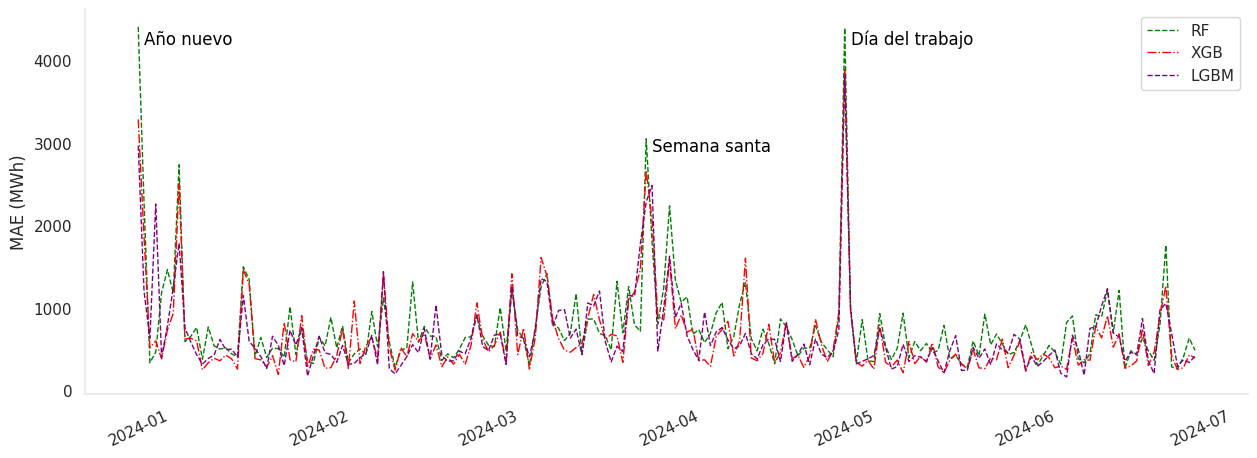

In [284]:
a = []
for i in range(1,4):
  mae = (y_datos[fin_val:]-prediccion[i]["pred"]).abs()
  b = mae.groupby(mae.index.date).mean()
  a.append(b)
error = pd.DataFrame({"RF":a[0], "XGB":a[1], "LGBM":a[2]})

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.spines["left"].set_color("#e8e8e8")
ax.spines["bottom"].set_color("#e8e8e8")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.legend(loc='upper left', fontsize='small', fancybox=True)
plt.ylabel('MAE (MWh)')
plt.xlabel('')
plt.text(pd.Timestamp('2024-01-02'), 4200, 'Año nuevo', fontsize=12, color='black')
plt.text(pd.Timestamp('2024-03-29'), 2900, 'Semana santa', fontsize=12, color='black')
plt.text(pd.Timestamp('2024-05-02'), 4200, 'Día del trabajo', fontsize=12, color='black')
estilo = ["--", "-.", "--"]
for i in range(0,3):
  ts = error.iloc[:,i]
  ts.plot(color=colores[i+2], rot = 25, linewidth=1, linestyle = estilo[i], legend = "a")

Se puede ver que hay días en donde el error se dispara en las predicciones de los 3 modelos, justamente estas fechas corresponden a días festivos en España. En la siguiente tabla, vemos en orden descendente los días con mayor MAE para cada modelo.

In [285]:
a = []
for i in range(1,4):
  mae = (y_datos[fin_val:]-prediccion[i]["pred"]).abs()
  b = mae.groupby(mae.index.date).mean().sort_values(ascending=False)
  a.append(b.index[:5])
pd.DataFrame({"RF":a[0], "XGB":a[1], "LGBM":a[2]})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



RF         XGB        LGBM
0  2024-01-01  2024-05-01  2024-05-01
1  2024-05-01  2024-01-01  2024-01-01
2  2024-03-28  2024-03-28  2024-03-29
3  2024-01-08  2024-01-08  2024-03-28
4  2024-01-02  2024-03-29  2024-01-04

Es clara la tendencia a predecir de peor manera durante los festivos, esto indica que los patrones de consumo de energía durante estas fechas difieren totalmente de la normalidad, así que incluir esta información durante el entrenamiento de los modelos puede mejorar su rendimiento notablemente. A continuación vamos a cuantificar las diferencias de MAE entre los días festivos y no festivos del periodo de prueba (Enero - Junio /2024)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-286-6795eae9c05e>:27: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-286-6795eae9c05e>:28: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1475: DeprecationWarning:

Conversion of an array with ndim > 0 to a sc

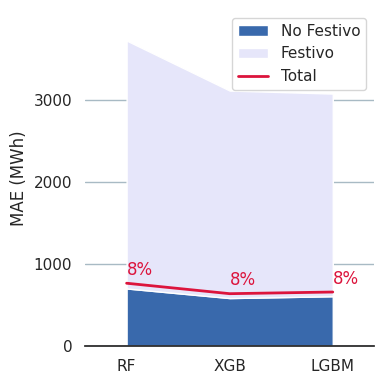

In [286]:
feriados = pd.to_datetime(['2024-01-01', '2024-01-06', '2024-03-28', '2024-03-29', '2024-05-01'])
a = []
for i in range(1,4):
  mae = (y_datos[fin_val:]-prediccion[i]["pred"]).abs()
  b = mae.groupby(mae.index.date).mean()
  b = b.reset_index()
  b["index"] = pd.to_datetime(b["index"])
  f = b[b['index'].isin(feriados)][0].mean()
  nf = b[~b['index'].isin(feriados)][0].mean()
  a.append([nf,f,mae.mean()])
df = pd.DataFrame(a, columns=["No Festivo","Festivo","Total"]).transpose()
df.columns = ['RF', 'XGB', 'LGBM']

fig, ax = plt.subplots(figsize=(4, 4))
ax.stackplot(df.columns, df.iloc[0:2,:], colors=["#3969AC","#E6E6FA"], labels=df.index);
t = ax.plot(df.columns,df.iloc[2,:], color="#DC143C", lw=2, label='Total')
ax.set_ylabel("MAE (MWh)")
ax.legend()
ax.yaxis.set_ticks([i * 1000 for i in range(0, 4)])
ax.grid(axis = "y", color="#A8BAC4")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.margins(x=0.2, y=0.1)

for c in df.columns:
  punto = round(100*(df[c][2]-df[c][0])/df[c][2])
  plt.annotate(str(punto)+"%", (c, df[c][2]+100), color="#DC143C")
fig.tight_layout()
plt.show()

La diferencia es marcada y se estima que el incremento de error en los días festivos representa un aumento del 8% del MAE total.